# Single WAV + FFT + Entropy : TensorFlow Speech Recognition Challenge

- Reading data is from this Kernel: https://www.kaggle.com/jamesrequa/convert-wav-to-spectogram (all credits to the respective writer) 


In [1]:
%reset -f
__author__ = 'Solomonk: https://www.kaggle.com/solomonk/'

import scipy.io
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy
import pandas as pd
from sklearn.metrics import roc_auc_score, mean_squared_error, roc_curve

import numpy
import pandas
from itertools import combinations

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.datasets import dump_svmlight_file
import numpy as np, h5py 

import os
from pathlib import Path
import IPython.display as ipd

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
%matplotlib inline

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

sample_submission.7z
sample_submission.csv
test
test.7z
train
train.7z



/home/ser/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
print(check_output(["ls", "../input/train"]).decode("utf8"))
folders = os.listdir("../input/train/audio")

audio
LICENSE
README.md
testing_list.txt
validation_list.txt



In [3]:
train_audio_path = '../input/train/audio'

train_labels = os.listdir(train_audio_path)
train_labels.remove('_background_noise_')
print(f'Number of labels: {len(train_labels)}')

labels_to_keep = ['yes', 'no', 'up', 'down', 'left',
                  'right', 'on', 'off', 'stop', 'go', 'silence']

train_file_labels = dict()
for label in train_labels:
    files = os.listdir(train_audio_path + '/' + label)
    for f in files:
        train_file_labels[label + '/' + f] = label

train = pd.DataFrame.from_dict(train_file_labels, orient='index')
train = train.reset_index(drop=False)
train = train.rename(columns={'index': 'file', 0: 'folder'})
train = train[['folder', 'file']]
train = train.sort_values('file')
train = train.reset_index(drop=True)
print(train.shape)

def remove_label_from_file(label, fname):
    return fname[len(label)+1:]

train['file'] = train.apply(lambda x: remove_label_from_file(*x), axis=1)
train['label'] = train['folder'].apply(lambda x: x if x in labels_to_keep else 'unknown')

Number of labels: 30
(64721, 2)


In [4]:
from PIL import Image
import numpy as np

#---------------------------------------------------------------#
def entropy(signal):
    '''
    function returns entropy of a signal
    signal must be a 1-D numpy array
    '''
    lensig=signal.size
    symset=list(set(signal))
    numsym=len(symset)
    propab=[np.size(signal[signal==i])/(1.0*lensig) for i in symset]
    ent=np.sum([p*np.log2(1.0/p) for p in propab])
    return ent
#---------------------------------------------------------------#    

# Plot Signal

/home/ser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  # Remove the CWD from sys.path while we load stuff.
/home/ser/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  # Remove the CWD from sys.path while we load stuff.


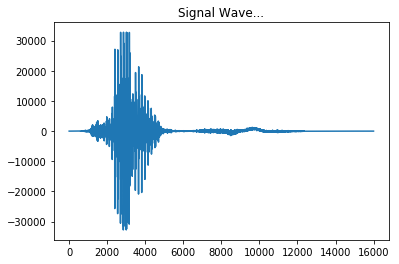

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys

spf = wave.open(str(train_audio_path) + '/house/61e50f62_nohash_1.wav','r')

#Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, 'Int16')

plt.figure(1)
plt.title('Signal Wave...')
plt.plot(signal)
plt.show()

# Plot FFT

[ 0.          0.00208281  0.00416563 ... -0.00624844 -0.00416563
 -0.00208281]


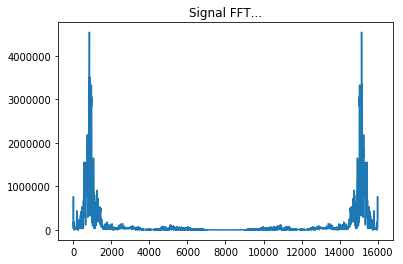

In [6]:
import numpy as np
import scipy.io.wavfile
import scipy.fftpack

t = scipy.linspace(0,120,4000)
x = scipy.io.wavfile.read(str(train_audio_path) + '/house/61e50f62_nohash_1.wav')[1]
FFT = abs(scipy.fft(x))
freqs = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])
print (np.array(freqs))

%matplotlib inline
plt.figure(1)
plt.title('Signal FFT...')
plt.plot(FFT)
plt.show()

# Entropy

In [7]:
x_ent=x.ravel()
entropy(x_ent)

10.046606813307758

In [22]:
def nextpow2(i):
    n = 1
    while n < i:
        n *= 2
    return n
    
def featurePSD(eegdata, Fs):
    # 1. Compute the PSD
    winSampleLength, nbCh = len(eegdata), 1

    # Apply Hamming window
    w = np.hamming(winSampleLength)
    dataWinCentered = eegdata - np.mean(eegdata, axis=0) # Remove offset
    dataWinCenteredHam = (dataWinCentered.T*w).T

    NFFT = nextpow2(winSampleLength)/2
    print(NFFT)
    Y = np.fft.fft(dataWinCenteredHam, n=NFFT, axis=0)/winSampleLength
    PSD = 2*np.abs(Y[0:NFFT/2,:])
    f = Fs/2*np.linspace(0,1,NFFT/2)

    # SPECTRAL FEATURES
    # Average of band powers
    # Delta <4
    ind_delta, = np.where(f<4)
    meanDelta = np.mean(PSD[ind_delta,:],axis=0)
    # Theta 4-8
    ind_theta, = np.where((f>=4) & (f<=8))
    meanTheta = np.mean(PSD[ind_theta,:],axis=0)
    # Alpha 8-12
    ind_alpha, = np.where((f>=8) & (f<=12))
    meanAlpha = np.mean(PSD[ind_alpha,:],axis=0)
    # Beta 12-30
    ind_beta, = np.where((f>=12) & (f<30))
    meanBeta = np.mean(PSD[ind_beta,:],axis=0)
    feature_vector = np.concatenate((meanDelta, meanTheta, meanAlpha, meanBeta),axis=0)
    feature_vector = np.log10(feature_vector)
    return feature_vector

In [23]:
#x = scipy.io.wavfile.read(str(train_audio_path) + '/house/61e50f62_nohash_1.wav')
sample_rate, samples = wavfile.read(str(train_audio_path) + '/house/61e50f62_nohash_1.wav')
print(len(samples))
psd=featurePSD (samples, 16000)

plt.plot(samples)
sample_rate



16000
8192.0


TypeError: integer argument expected, got float

In [17]:
# NE